In [1]:
# Load modules
import pandas as pd
import geopandas as gpd
import richdem as rd
import elevation
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import all data

# Buildings - building footprints of Shasta County, CA
buildings = gpd.read_file('./data/BuildingFootprints.shp')
buildings = buildings[['OBJECTID', 'BuildingTy', 'geometry']]

# Road data - road data from Shasta County, CA
roads = gpd.read_file('./data/Roads.shp')
roads = roads[['GISNUM', 'Functional', 'geometry']]

# Cities - major city footprints across CA
cities = gpd.read_file('./data/City_Boundaries.geojson')

# Fire perimeter - all Cali fires
all_fires = gpd.read_file('./data/California_Fire_Perimeters_(all).shp')
all_fires = all_fires[['YEAR_', 'FIRE_NAME', 'CAUSE', 'COMPLEX_NA', 'GIS_ACRES', 'geometry']]

# Census tracts - all California
tracts = gpd.read_file('./data/tl_2023_06_tract.shp')
tracts = tracts[['GEOID', 'NAME', 'geometry']]

In [4]:
# Check shape of all downloaded data

print('Building shape:', buildings.shape)
print('Roads shape:', roads.shape)
print('Cities shape:', cities.shape)
print('All fires shape:', all_fires.shape)

Building shape: (127101, 3)
Roads shape: (15450, 3)
Cities shape: (482, 7)
All fires shape: (21926, 6)


In [5]:
# Prompt user for input to select a Cali fire - we chose the Carr fire
user_fire = input('Enter fire name:')
# Check that user provided fire is in dataset
if user_fire.upper() in all_fires['FIRE_NAME'].str.upper().values:
    selected_fire = all_fires[all_fires['FIRE_NAME'] == user_fire.upper()]
    selected_fire_name = selected_fire.iloc[0]['FIRE_NAME']
else:
    print('The provided fire name does not exist in the dataset. Please enter a different fire name.')

In [6]:
# Project all layers to UTM Zone 10N (EPSG code 32610) 
user_proj = str(input('Enter EPSG code for file projection'))
selected_fire.to_crs(f'EPSG: {user_proj}', inplace=True) 
buildings.to_crs(f'EPSG: {user_proj}', inplace=True) 
cities.to_crs(f'EPSG: {user_proj}', inplace=True) 
roads.to_crs(f'EPSG: {user_proj}', inplace=True) 
#svi.to_crs(f'EPSG: {user_proj}', inplace=True) 
tracts.to_crs(f'EPSG: {user_proj}', inplace=True)

c:\Users\cayle.LAPTOP-QMLQMN4A\miniconda3\envs\geog3198_final\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# Get census tracts that intersect with fire scar
tracts_in_fire = gpd.overlay(tracts, selected_fire, how = 'intersection')
tracts_in_fire

,GEOID,NAME,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry
0,06089011600,116,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588..."
1,06089012302,123.02,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4..."
2,06089012500,125,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840..."
3,06089010702,107.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012..."
4,06089011001,110.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633..."
5,06089012400,124,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435..."
6,06089010704,107.04,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4..."
7,06089010603,106.03,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665..."
8,06105000101,1.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591..."
9,06089010602,106.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707..."


In [8]:
# Intersect all buildings with fire scar to identify the total number of impacted buildings
buildings_burned = gpd.overlay(selected_fire, buildings, how = 'intersection')
buildings_burned_count = len(buildings_burned)
print(f'{buildings_burned_count} buildings were impacted by the {selected_fire_name.capitalize()} fire.')

4199 buildings were impacted by the Carr fire.


In [9]:
# Add count column for groupby() and sum the number of buildings burned by building type
buildings_burned['Count'] = 1
# Remane BuildingTy to Building Type
buildings_burned.rename(columns = {'BuildingTy': 'Building Type'}, inplace = True)

In [10]:
# Sum the buildings burned by type
type_burned = pd.DataFrame(buildings_burned.groupby(['Building Type'])['Count'].sum())

# Reset index
type_burned = type_burned.reset_index()
type_burned

,Building Type,Count
0,Barn,76
1,Commercial,82
2,Garage,427
3,General,243
4,Municipal,78
5,Out Building,1058
6,Religious,4
7,Residential,2231


In [11]:
# Print how many of each building type was impacted by the selected fire 
print(f'The {selected_fire_name.capitalize()} fire impacted:')
for index, row in type_burned.iterrows():
    building = row['Building Type']
    count = row['Count']
    print(f'- {count} {building} building types.')

The Carr fire impacted:
- 76 Barn building types.
- 82 Commercial building types.
- 427 Garage building types.
- 243 General building types.
- 78 Municipal building types.
- 1058 Out Building building types.
- 4 Religious building types.
- 2231 Residential building types.


In [12]:
# Bar plotter function - used for other class
def bar_plotter(data, x, y, title, colors, figsize):
    sns.set_context('notebook')
    sns.set_style("ticks")

    # Set up axis and style
    plt.subplots(figsize = figsize)
    sns.set_style("whitegrid")
    
    # Add data
    sns.barplot(x = x, y = y, data = data, palette = colors)

    # Add numbers to the top of bars
    for index, row in data.iterrows():
        plt.text(index, row[y], str(row[y]), ha='center', va='bottom', fontsize = 12)

    # Add title
    plt.title(title, fontsize = 20)

C:\Users\cayle.LAPTOP-QMLQMN4A\AppData\Local\Temp\ipykernel_24828\1015090760.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = x, y = y, data = data, palette = colors)
C:\Users\cayle.LAPTOP-QMLQMN4A\AppData\Local\Temp\ipykernel_24828\1015090760.py:11: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = x, y = y, data = data, palette = colors)


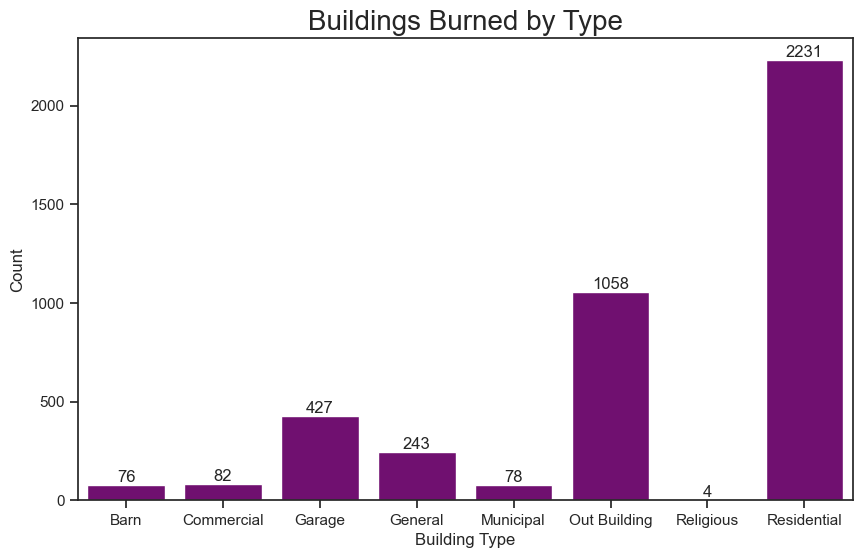

In [13]:
bar_plotter(data = type_burned,
            x = 'Building Type',
            y = 'Count',
            title = 'Buildings Burned by Type',
            colors = ['purple'],
            figsize = (10, 6))

In [14]:
# Spatial join with contains to see major cities in the fire perimeter
cities_in_fire = gpd.sjoin(cities, selected_fire, how = 'inner', predicate = 'intersects')
cities_in_fire

,OBJECTID,COUNTY,CITY,Shape__Area,Shape__Length,GlobalID,geometry,index_right,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES
339,340,Shasta,Redding,2.736538e+08,200002.486364,5edbca40-34c0-41e6-b12d-325de5565389,"MULTIPOLYGON (((557321.251 4502865.928, 557300...",20512,2018,CARR,10,None,229651.0


<Axes: >

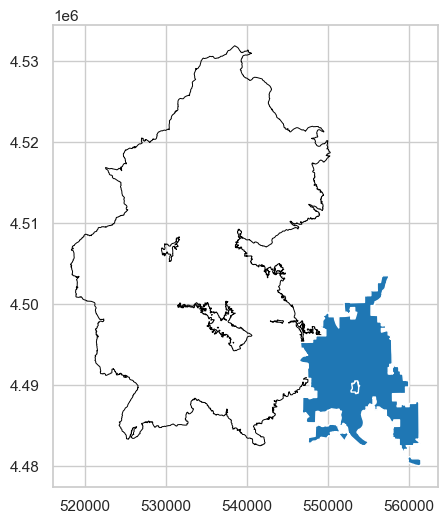

In [15]:
# Plots intersection of fire scar and major cities
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (6, 6))
#buildings_burned.plot(ax = ax)
selected_fire.plot(ax = ax, facecolor = 'none', edgecolor = 'black', lw = 0.7)
cities_in_fire.plot(ax = ax)

In [16]:
# Prompt user to select a building type for the MCE of risk for that building type - we did residential
selected_building = input('Enter building type (Barn, Commercial, Garage, General, Municipal, Out Building, Religious,Residential)')
if selected_building.capitalize() in buildings_burned['Building Type'].str.capitalize().values:
    print(f'The MCE of risk will focus on {selected_building} building types')
    selected_building = buildings_burned[buildings_burned['Building Type'] == selected_building.capitalize()]
else:
    raise TypeError('The building type you selected is not in the data. Please pick one of the following building types: Barn, Commercial, Garage, General, Municipal, Out Building, Religious,Residential')

The MCE of risk will focus on residential building types


In [17]:
selected_building

,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,OBJECTID,Building Type,geometry,Count
0,2018,CARR,10,None,229651.0,14,Residential,"POLYGON ((547789.237 4493118.572, 547797.834 4...",1
1,2018,CARR,10,None,229651.0,15,Residential,"POLYGON ((547835.000 4493050.781, 547835.090 4...",1
2,2018,CARR,10,None,229651.0,16,Residential,"POLYGON ((547768.034 4492977.034, 547760.581 4...",1
3,2018,CARR,10,None,229651.0,17,Residential,"POLYGON ((547854.071 4492930.510, 547846.648 4...",1
4,2018,CARR,10,None,229651.0,18,Residential,"POLYGON ((547801.073 4492900.380, 547805.880 4...",1
...,...,...,...,...,...,...,...,...,...
4182,2018,CARR,10,None,229651.0,126685,Residential,"POLYGON ((545266.547 4497388.558, 545269.150 4...",1
4185,2018,CARR,10,None,229651.0,126688,Residential,"POLYGON ((545395.548 4496628.715, 545407.454 4...",1
4191,2018,CARR,10,None,229651.0,126731,Residential,"POLYGON ((526877.553 4506464.838, 526874.307 4...",1
4195,2018,CARR,10,None,229651.0,126735,Residential,"POLYGON ((527483.409 4502594.324, 527488.917 4...",1


In [18]:
# Selected building grouped by census tract
selected_building_in_tract = gpd.overlay(selected_building, tracts, how = 'intersection')
selected_building_in_tract

,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,OBJECTID,Building Type,Count,GEOID,NAME,geometry
0,2018,CARR,10,None,229651.0,14,Residential,1,06089010602,106.02,"POLYGON ((547797.834 4493107.030, 547782.346 4..."
1,2018,CARR,10,None,229651.0,15,Residential,1,06089010602,106.02,"POLYGON ((547835.090 4493054.044, 547841.852 4..."
2,2018,CARR,10,None,229651.0,16,Residential,1,06089010602,106.02,"POLYGON ((547760.581 4492961.283, 547743.985 4..."
3,2018,CARR,10,None,229651.0,17,Residential,1,06089010602,106.02,"POLYGON ((547846.648 4492916.570, 547841.026 4..."
4,2018,CARR,10,None,229651.0,18,Residential,1,06089010602,106.02,"POLYGON ((547805.880 4492897.705, 547804.030 4..."
...,...,...,...,...,...,...,...,...,...,...,...
2226,2018,CARR,10,None,229651.0,126685,Residential,1,06089010603,106.03,"POLYGON ((545269.150 4497388.558, 545269.150 4..."
2227,2018,CARR,10,None,229651.0,126688,Residential,1,06089010603,106.03,"POLYGON ((545407.454 4496629.271, 545407.832 4..."
2228,2018,CARR,10,None,229651.0,126731,Residential,1,06089012400,124,"POLYGON ((526874.307 4506457.096, 526861.158 4..."
2229,2018,CARR,10,None,229651.0,126735,Residential,1,06089012400,124,"POLYGON ((527488.917 4502586.182, 527484.800 4..."


In [19]:
# Use groupby() to sum the total selected buildings per census tract
selected_buildings_in_tract = pd.DataFrame(selected_building_in_tract.groupby(['GEOID'])['Count'].sum())
# Rename column
selected_buildings_in_tract.rename(columns = {'Count': 'All Selected Buildings'}, inplace = True)

In [20]:
# Overlay ALL buildings with the census tracts - used to determine % of selected building in census tract
all_buildings_in_tract = gpd.overlay(buildings, tracts, how = 'intersection')
# Add count column for groupby()
all_buildings_in_tract['count'] = 1
all_buildings_in_tract = pd.DataFrame(all_buildings_in_tract.groupby(['GEOID'])['count'].sum())
all_buildings_in_tract.rename(columns = {'count': 'All Buildings'}, inplace = True)
all_buildings_in_tract

,All Buildings
GEOID,
06089010100,709
06089010200,1221
06089010300,1759
06089010400,3021
06089010500,2310
06089010601,1160
06089010602,2496
06089010603,1364
06089010702,1987


In [21]:
# Join dataframes with all buildings per census tract and selected buildings per census tract into one dataframe
building_count = all_buildings_in_tract.join(selected_buildings_in_tract, on = 'GEOID', how = 'left')

# Find the % of the selected building in each census tract
building_count['% Select'] = building_count['All Selected Buildings'] / building_count['All Buildings']

# Fill NaN with 0s
building_count = building_count[['All Buildings', 'All Selected Buildings', '% Select']].fillna(0)
building_count

,All Buildings,All Selected Buildings,% Select
GEOID,,,
06089010100,709,0.0,0.000000
06089010200,1221,0.0,0.000000
06089010300,1759,0.0,0.000000
06089010400,3021,0.0,0.000000
06089010500,2310,0.0,0.000000
06089010601,1160,0.0,0.000000
06089010602,2496,248.0,0.099359
06089010603,1364,554.0,0.406158
06089010702,1987,448.0,0.225466


In [23]:
building_count.reset_index().head()

,GEOID,All Buildings,All Selected Buildings,% Select
0,06089010100,709,0.0,0.0
1,06089010200,1221,0.0,0.0
2,06089010300,1759,0.0,0.0
3,06089010400,3021,0.0,0.0
4,06089010500,2310,0.0,0.0


In [24]:
# Merge buildings with census tracts in fire
building_fire = pd.merge(left = tracts_in_fire,
                         right = building_count,
                         how = 'left',
                         on = 'GEOID')
building_fire

,GEOID,NAME,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry,All Buildings,All Selected Buildings,% Select
0,06089011600,116,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588...",3710.0,116.0,0.031267
1,06089012302,123.02,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4...",6142.0,1.0,0.000163
2,06089012500,125,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840...",2173.0,0.0,0.000000
3,06089010702,107.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012...",1987.0,448.0,0.225466
4,06089011001,110.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633...",1796.0,1.0,0.000557
5,06089012400,124,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435...",5470.0,861.0,0.157404
6,06089010704,107.04,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4...",1941.0,2.0,0.001030
7,06089010603,106.03,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665...",1364.0,554.0,0.406158
8,06105000101,1.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591...",NaN,NaN,NaN
9,06089010602,106.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707...",2496.0,248.0,0.099359


In [25]:
# Overlay roads with census
roads_in_tracts = gpd.overlay(roads, tracts, how = 'intersection')
roads_in_tracts

,GISNUM,Functional,GEOID,NAME,geometry
0,1010000,Minor Arterial,06089012200,122,"MULTILINESTRING ((561861.318 4476702.823, 5618..."
1,1010000,Minor Arterial,06089012102,121.02,"MULTILINESTRING ((561829.341 4476709.405, 5618..."
2,1010001,Minor Arterial,06089012102,121.02,"LINESTRING (562882.302 4477646.614, 563013.732..."
3,1010002,Local,06089012200,122,"LINESTRING (564569.986 4477850.460, 564596.427..."
4,1010003,Local,06089012200,122,"LINESTRING (564596.427 4477878.432, 564643.348..."
...,...,...,...,...,...
16503,1023008,Local,06089012400,124,"LINESTRING (530591.363 4506739.236, 530590.611..."
16504,1013927,Local,06089012400,124,"LINESTRING (530594.369 4506707.527, 530582.415..."
16505,1018138,Local,06089012500,125,"LINESTRING (551951.434 4528444.043, 551942.183..."
16506,1023010,Local,06089012500,125,"LINESTRING (551951.434 4528444.043, 551960.897..."


<Axes: >

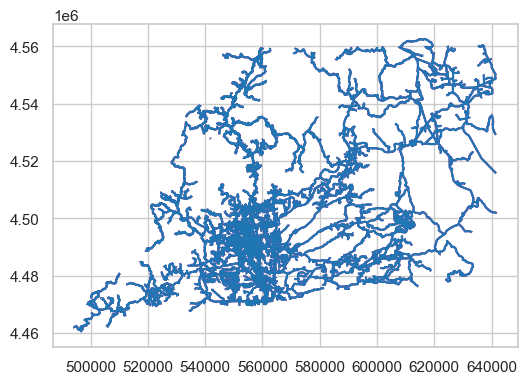

In [26]:
# Plots intersection of fire scar and major cities
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (6, 6))
roads_in_tracts.plot(ax = ax, color = 'purple') #, facecolor = 'none', edgecolor = 'black', lw = 0.7)
roads.plot(ax = ax)

In [27]:
# Find the length of each road
roads_in_tracts['Road Length_m'] = roads_in_tracts['geometry'].length 
roads_in_tracts['Road Length_km'] = roads_in_tracts['Road Length_m'] / 1000

roads_in_tracts

,GISNUM,Functional,GEOID,NAME,geometry,Road Length_m,Road Length_km
0,1010000,Minor Arterial,06089012200,122,"MULTILINESTRING ((561861.318 4476702.823, 5618...",60.919832,0.060920
1,1010000,Minor Arterial,06089012102,121.02,"MULTILINESTRING ((561829.341 4476709.405, 5618...",1380.564884,1.380565
2,1010001,Minor Arterial,06089012102,121.02,"LINESTRING (562882.302 4477646.614, 563013.732...",195.238768,0.195239
3,1010002,Local,06089012200,122,"LINESTRING (564569.986 4477850.460, 564596.427...",38.491384,0.038491
4,1010003,Local,06089012200,122,"LINESTRING (564596.427 4477878.432, 564643.348...",372.415378,0.372415
...,...,...,...,...,...,...,...
16503,1023008,Local,06089012400,124,"LINESTRING (530591.363 4506739.236, 530590.611...",347.277261,0.347277
16504,1013927,Local,06089012400,124,"LINESTRING (530594.369 4506707.527, 530582.415...",41.702532,0.041703
16505,1018138,Local,06089012500,125,"LINESTRING (551951.434 4528444.043, 551942.183...",62.272574,0.062273
16506,1023010,Local,06089012500,125,"LINESTRING (551951.434 4528444.043, 551960.897...",49.836887,0.049837


In [28]:
# Find the length of all roads by census tract using groupby
roads_in_tracts = pd.DataFrame(roads_in_tracts.groupby(['GEOID'])['Road Length_km'].sum())
roads_in_tracts.head()

,Road Length_km
GEOID,
06035040100,10.065915
06049000200,0.020476
06089010100,25.386993
06089010200,27.437189
06089010300,49.055786


In [29]:
tracts['Area'] = tracts['geometry'].area / 1000000

In [30]:
tracts

,GEOID,NAME,geometry,Area
0,06001442700,4427,"POLYGON ((586824.176 4155157.747, 586826.343 4...",1.233260
1,06001442800,4428,"POLYGON ((588152.592 4154119.056, 588158.251 4...",1.277879
2,06037204920,2049.20,"POLYGON ((943100.474 3774727.838, 943100.801 3...",0.913673
3,06037205110,2051.10,"POLYGON ((941513.105 3775390.901, 941520.940 3...",0.288117
4,06037320101,3201.01,"POLYGON ((919895.700 3804751.921, 920027.656 3...",0.682929
...,...,...,...,...
9124,06059001303,13.03,"POLYGON ((966148.524 3765255.545, 966175.645 3...",1.185055
9125,06059001304,13.04,"POLYGON ((966128.353 3765657.711, 966209.066 3...",1.258473
9126,06059001401,14.01,"POLYGON ((966833.940 3767566.049, 966833.850 3...",1.616257
9127,06013367200,3672,"POLYGON ((557491.371 4201972.677, 557491.972 4...",1.321311


In [31]:
# Merge the census tracts into the road dataframe to then calculate road density per census tract (census tract area is in km**2)
road_count = roads_in_tracts.merge(right = tracts, how = 'inner', on = 'GEOID')
road_count.head()

,GEOID,Road Length_km,NAME,geometry,Area
0,06035040100,10.065915,401,"POLYGON ((640474.472 4530478.154, 640482.212 4...",7619.093206
1,06049000200,0.020476,2,"POLYGON ((627871.674 4645369.721, 628262.675 4...",2475.529680
2,06089010100,25.386993,101,"POLYGON ((550891.037 4493000.673, 550914.302 4...",1.357677
3,06089010200,27.437189,102,"POLYGON ((551793.832 4493566.145, 552503.471 4...",3.380166
4,06089010300,49.055786,103,"POLYGON ((553076.800 4491440.156, 553172.270 4...",4.988880


In [32]:
# Calculate road density - units are road length (km) / census tract area (km**2)
road_count['Road_Density'] = road_count['Road Length_km'] / road_count['Area']
road_count.head()

,GEOID,Road Length_km,NAME,geometry,Area,Road_Density
0,06035040100,10.065915,401,"POLYGON ((640474.472 4530478.154, 640482.212 4...",7619.093206,0.001321
1,06049000200,0.020476,2,"POLYGON ((627871.674 4645369.721, 628262.675 4...",2475.529680,0.000008
2,06089010100,25.386993,101,"POLYGON ((550891.037 4493000.673, 550914.302 4...",1.357677,18.698845
3,06089010200,27.437189,102,"POLYGON ((551793.832 4493566.145, 552503.471 4...",3.380166,8.117113
4,06089010300,49.055786,103,"POLYGON ((553076.800 4491440.156, 553172.270 4...",4.988880,9.833025


In [33]:
density_min = road_count['Road_Density'].min()
density_max = road_count['Road_Density'].max()
print(f'Minimum road density: {density_min}\n Maximum road density: {density_max}')

Minimum road density: 6.044989627372354e-07
 Maximum road density: 18.69884469531888


In [34]:
# Scale road density using min max scaling to get values btwn 0 and 1 - and take the reciprocal so lower road densities are weighted more in the final MCE
road_count['Road_Density_Scaled'] = 1- ((road_count['Road_Density'] - density_min) / (density_max - density_min))
road_count

,GEOID,Road Length_km,NAME,geometry,Area,Road_Density,Road_Density_Scaled
0,06035040100,10.065915,401,"POLYGON ((640474.472 4530478.154, 640482.212 4...",7619.093206,1.321143e-03,0.999929
1,06049000200,0.020476,2,"POLYGON ((627871.674 4645369.721, 628262.675 4...",2475.529680,8.271452e-06,1.000000
2,06089010100,25.386993,101,"POLYGON ((550891.037 4493000.673, 550914.302 4...",1.357677,1.869884e+01,0.000000
3,06089010200,27.437189,102,"POLYGON ((551793.832 4493566.145, 552503.471 4...",3.380166,8.117113e+00,0.565903
4,06089010300,49.055786,103,"POLYGON ((553076.800 4491440.156, 553172.270 4...",4.988880,9.833025e+00,0.474137
5,06089010400,45.000371,104,"POLYGON ((551595.736 4491253.597, 551610.435 4...",6.345216,7.092015e+00,0.620724
6,06089010500,38.529006,105,"POLYGON ((549204.391 4491663.596, 549331.940 4...",4.254756,9.055515e+00,0.515718
7,06089010601,27.396399,106.01,"POLYGON ((547867.057 4489941.290, 547927.882 4...",5.267285,5.201238e+00,0.721842
8,06089010602,53.931114,106.02,"POLYGON ((547463.132 4492999.268, 547697.963 4...",7.239080,7.449996e+00,0.601580
9,06089010603,51.298155,106.03,"POLYGON ((543660.360 4493026.319, 543661.997 4...",21.858389,2.346841e+00,0.874493


In [35]:
road_fire = pd.merge(left = tracts_in_fire,
                     right = road_count,
                     how = 'left',
                     on = 'GEOID')
road_fire

,GEOID,NAME_x,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry_x,Road Length_km,NAME_y,geometry_y,Area,Road_Density,Road_Density_Scaled
0,06089011600,116,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588...",94.320411,116,"POLYGON ((545581.718 4502395.161, 545582.782 4...",54.165363,1.741342,0.906874
1,06089012302,123.02,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4...",179.407614,123.02,"POLYGON ((539080.215 4484087.927, 539081.284 4...",95.138788,1.885746,0.899152
2,06089012500,125,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840...",649.262219,125,"POLYGON ((531826.341 4524817.495, 531834.188 4...",1268.484138,0.511841,0.972627
3,06089010702,107.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012...",41.249727,107.02,"POLYGON ((546860.846 4495848.444, 546878.443 4...",12.458792,3.310893,0.822936
4,06089011001,110.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633...",62.759530,110.01,"POLYGON ((540235.396 4484891.727, 540246.147 4...",45.844922,1.368953,0.926789
5,06089012400,124,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435...",804.854821,124,"POLYGON ((494150.558 4461973.936, 494278.231 4...",1603.891165,0.501814,0.973163
6,06089010704,107.04,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4...",26.735396,107.04,"POLYGON ((549817.844 4497390.767, 549934.439 4...",4.664762,5.731353,0.693492
7,06089010603,106.03,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665...",51.298155,106.03,"POLYGON ((543660.360 4493026.319, 543661.997 4...",21.858389,2.346841,0.874493
8,06105000101,1.01,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591...",42.350576,1.01,"POLYGON ((495901.286 4506150.789, 495908.931 4...",1489.474994,0.028433,0.998479
9,06089010602,106.02,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707...",53.931114,106.02,"POLYGON ((547463.132 4492999.268, 547697.963 4...",7.239080,7.449996,0.601580


In [36]:
# Read in SVI data
svi = pd.read_csv('./data/SVI_clean_data.csv', usecols = ['FIPS', 'NOVEH_PER', 'POV150_PER', 'AGE65_PER', 'AGE17_PER'])
# Convert FIPS data type to string to be able to add a leading zero to match GEOID for other dataframes
svi['FIPS'] = svi['FIPS'].astype(str)
svi.head()

,FIPS,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER
0,6089010100,0.113850,0.303991,0.148474,0.100939
1,6089010200,0.054923,0.323434,0.171684,0.164361
2,6089010300,0.020824,0.245080,0.112128,0.273227
3,6089010400,0.015281,0.225843,0.161348,0.203596
4,6089010500,0.046220,0.360966,0.130988,0.234656


In [37]:
# Add leading zero to FIPS zode
svi['FIPS'] = '0' + svi['FIPS']
svi.head()

,FIPS,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER
0,06089010100,0.113850,0.303991,0.148474,0.100939
1,06089010200,0.054923,0.323434,0.171684,0.164361
2,06089010300,0.020824,0.245080,0.112128,0.273227
3,06089010400,0.015281,0.225843,0.161348,0.203596
4,06089010500,0.046220,0.360966,0.130988,0.234656


In [38]:
dem_path = './data/carrdem_clipped.tif'
shasta_dem = rd.LoadGDAL(dem_path, no_data = -9999)

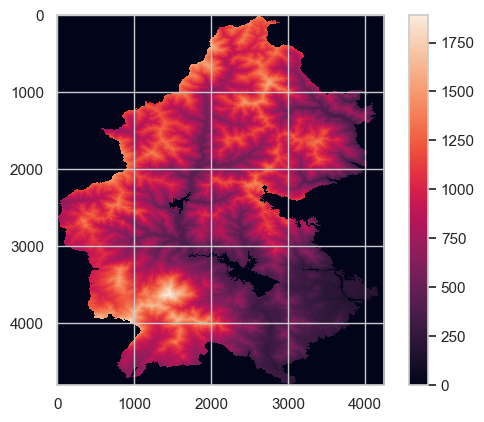

In [39]:
plt.imshow(shasta_dem, interpolation='none')
plt.colorbar()
plt.show()

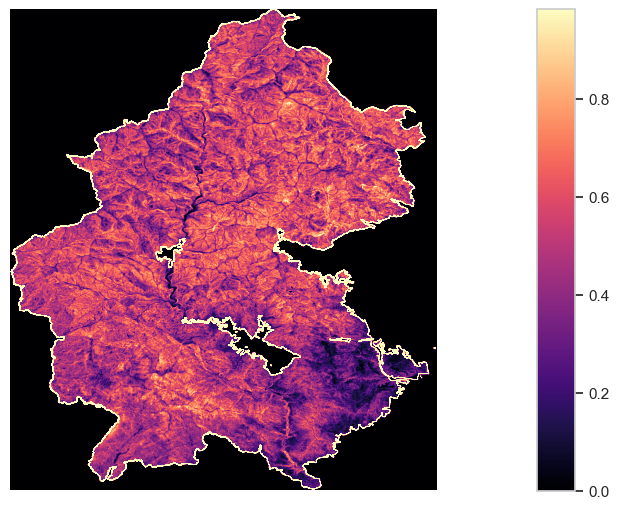

In [40]:
slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

In [41]:
# Save slope as a tif
rd.SaveGDAL('./data/shasta_slope.tif', slope)


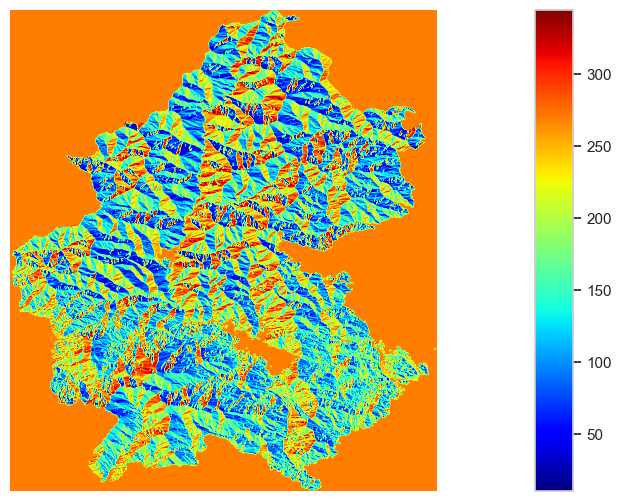

In [42]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()
# Just for fun because aspect maps are pretty

In [43]:
# Get census tracts that intersect with fire scar
tracts_in_fire = gpd.overlay(tracts, selected_fire, how = 'intersection')
tracts_in_fire.shape

(10, 9)

In [44]:
from rasterstats import zonal_stats
mean_slop = zonal_stats(vectors= tracts_in_fire,
                        raster= './data/shasta_slope.tif',
                        nodata=-9999,
                        stats=['mean'],
                        all_touched = True)

In [45]:
mean_slope = pd.DataFrame(mean_slop)
mean_slope.columns = ['mean_slope']
mean_slope

,mean_slope
0,1.973738
1,0.748638
2,0.935218
3,0.519723
4,1.506738
5,0.638780
6,4.892198
7,0.356039
8,1.053379
9,1.186642


In [46]:
slope_tracts = pd.merge(left = tracts_in_fire,
                        right = mean_slope,
                        how = 'left',
                        right_index = True,
                        left_index = True)

slope_tracts

,GEOID,NAME,Area,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry,mean_slope
0,06089011600,116,54.165363,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588...",1.973738
1,06089012302,123.02,95.138788,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4...",0.748638
2,06089012500,125,1268.484138,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840...",0.935218
3,06089010702,107.02,12.458792,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012...",0.519723
4,06089011001,110.01,45.844922,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633...",1.506738
5,06089012400,124,1603.891165,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435...",0.638780
6,06089010704,107.04,4.664762,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4...",4.892198
7,06089010603,106.03,21.858389,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665...",0.356039
8,06105000101,1.01,1489.474994,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591...",1.053379
9,06089010602,106.02,7.239080,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707...",1.186642


In [47]:
# min max scaling for slope values
min_slope = slope_tracts['mean_slope'].min()
max_slope = slope_tracts['mean_slope'].max()

print(f'Minimum slope: {min_slope}\n Maximum slope: {max_slope}')

Minimum slope: 0.35603915708462613
 Maximum slope: 4.892198205631685


In [48]:
# Min max scaling on slope - high slope = more vulnerable
slope_tracts['slope_scaled'] = (slope_tracts['mean_slope'] - min_slope) / (max_slope - min_slope)
slope_tracts

,GEOID,NAME,Area,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry,mean_slope,slope_scaled
0,06089011600,116,54.165363,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588...",1.973738,0.356623
1,06089012302,123.02,95.138788,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4...",0.748638,0.086549
2,06089012500,125,1268.484138,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840...",0.935218,0.127680
3,06089010702,107.02,12.458792,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012...",0.519723,0.036084
4,06089011001,110.01,45.844922,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633...",1.506738,0.253673
5,06089012400,124,1603.891165,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435...",0.638780,0.062330
6,06089010704,107.04,4.664762,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4...",4.892198,1.000000
7,06089010603,106.03,21.858389,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665...",0.356039,0.000000
8,06105000101,1.01,1489.474994,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591...",1.053379,0.153729
9,06089010602,106.02,7.239080,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707...",1.186642,0.183107


In [49]:
# Extract GEOID and slope_scales columns
slope = slope_tracts.copy()
slope = slope[['GEOID', 'slope_scaled']]
slope

,GEOID,slope_scaled
0,06089011600,0.356623
1,06089012302,0.086549
2,06089012500,0.127680
3,06089010702,0.036084
4,06089011001,0.253673
5,06089012400,0.062330
6,06089010704,1.000000
7,06089010603,0.000000
8,06105000101,0.153729
9,06089010602,0.183107


In [50]:
# Merge svi data with tracts in fire
svi_data = pd.merge(left = tracts_in_fire,
                    right = svi,
                    how = 'left',
                    left_on = 'GEOID',
                    right_on = 'FIPS')
svi_data

,GEOID,NAME,Area,YEAR_,FIRE_NAME,CAUSE,COMPLEX_NA,GIS_ACRES,geometry,FIPS,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER
0,06089011600,116,54.165363,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((548637.845 4496851.573, 548588...",06089011600,0.014006,0.307082,0.210624,0.171247
1,06089012302,123.02,95.138788,2018,CARR,10,None,229651.0,"POLYGON ((539153.698 4484309.874, 539160.278 4...",06089012302,0.008005,0.106455,0.226878,0.184466
2,06089012500,125,1268.484138,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((531834.188 4524834.513, 531840...",06089012500,0.007185,0.397126,0.350098,0.073808
3,06089010702,107.02,12.458792,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((546997.876 4495850.972, 547012...",06089010702,0.051368,0.237825,0.228486,0.200133
4,06089011001,110.01,45.844922,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((541637.170 4483796.024, 541633...",06089011001,0.011316,0.097082,0.214413,0.210244
5,06089012400,124,1603.891165,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((525373.687 4491007.008, 525435...",06089012400,0.013216,0.191500,0.220005,0.197201
6,06089010704,107.04,4.664762,2018,CARR,10,None,229651.0,"POLYGON ((551104.391 4496945.923, 551074.758 4...",06089010704,0.079326,0.397718,0.263787,0.183917
7,06089010603,106.03,21.858389,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((543661.997 4493035.764, 543665...",06089010603,0.000000,0.097115,0.227305,0.292048
8,06105000101,1.01,1489.474994,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((533653.052 4527705.422, 533591...",NaN,NaN,NaN,NaN,NaN
9,06089010602,106.02,7.239080,2018,CARR,10,None,229651.0,"MULTIPOLYGON (((547697.963 4493662.699, 547707...",06089010602,0.024736,0.128476,0.249281,0.227229


In [51]:
# Extract SVI values and GEOID
svi_final = svi_data.copy()
svi_final = svi_final[['GEOID', 'NOVEH_PER', 'POV150_PER', 'AGE65_PER', 'AGE17_PER']]
svi_final

,GEOID,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER
0,06089011600,0.014006,0.307082,0.210624,0.171247
1,06089012302,0.008005,0.106455,0.226878,0.184466
2,06089012500,0.007185,0.397126,0.350098,0.073808
3,06089010702,0.051368,0.237825,0.228486,0.200133
4,06089011001,0.011316,0.097082,0.214413,0.210244
5,06089012400,0.013216,0.191500,0.220005,0.197201
6,06089010704,0.079326,0.397718,0.263787,0.183917
7,06089010603,0.000000,0.097115,0.227305,0.292048
8,06105000101,NaN,NaN,NaN,NaN
9,06089010602,0.024736,0.128476,0.249281,0.227229


In [52]:
# Extract building %
building = building_fire.copy()
building = building[['GEOID', '% Select']]
building

,GEOID,% Select
0,06089011600,0.031267
1,06089012302,0.000163
2,06089012500,0.000000
3,06089010702,0.225466
4,06089011001,0.000557
5,06089012400,0.157404
6,06089010704,0.001030
7,06089010603,0.406158
8,06105000101,NaN
9,06089010602,0.099359


In [53]:
# Extract road density scales
road = road_fire.copy()
road = road[['GEOID', 'Road_Density_Scaled']]
road

,GEOID,Road_Density_Scaled
0,06089011600,0.906874
1,06089012302,0.899152
2,06089012500,0.972627
3,06089010702,0.822936
4,06089011001,0.926789
5,06089012400,0.973163
6,06089010704,0.693492
7,06089010603,0.874493
8,06105000101,0.998479
9,06089010602,0.601580


In [54]:
# Merge all dataframes together
merge1 = pd.merge(left = building,
                  right = road,
                  how = 'left', 
                  on = 'GEOID')

merge2 = pd.merge(left = merge1,
                  right = svi_final,
                  how = 'left', 
                  on = 'GEOID')

merge_final = pd.merge(left = merge2,
                       right = slope,
                       how = 'left', 
                       on = 'GEOID')

merge_final

,GEOID,% Select,Road_Density_Scaled,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER,slope_scaled
0,06089011600,0.031267,0.906874,0.014006,0.307082,0.210624,0.171247,0.356623
1,06089012302,0.000163,0.899152,0.008005,0.106455,0.226878,0.184466,0.086549
2,06089012500,0.000000,0.972627,0.007185,0.397126,0.350098,0.073808,0.127680
3,06089010702,0.225466,0.822936,0.051368,0.237825,0.228486,0.200133,0.036084
4,06089011001,0.000557,0.926789,0.011316,0.097082,0.214413,0.210244,0.253673
5,06089012400,0.157404,0.973163,0.013216,0.191500,0.220005,0.197201,0.062330
6,06089010704,0.001030,0.693492,0.079326,0.397718,0.263787,0.183917,1.000000
7,06089010603,0.406158,0.874493,0.000000,0.097115,0.227305,0.292048,0.000000
8,06105000101,NaN,0.998479,NaN,NaN,NaN,NaN,0.153729
9,06089010602,0.099359,0.601580,0.024736,0.128476,0.249281,0.227229,0.183107


In [55]:
# Weight all variables and create MCE column
# Final weights:
    # % Building: 0.25 - high building density = more vulnerable
    # Road Density: 0.15 - low road density = more vulnerable
    # % No Vehicle: 0.15 - high % no vehicle = more vulnerable
    # % Poverty: 0.2 - high % poverty = more vulnerable
    # % Over 65: 0.1 - high % 65+ = more vulnerable
    # % Under 17: 0.1 - high % under 17 = more vulnerable
    # Slope: 0.05 - higher slope = more vulnerable

building_weight = 0.25
road_weight = 0.15
no_vehicle_weight = 0.15
poverty_weight = 0.2
over_65_weight = 0.1
under_17_weight = 0.1
slope_weight = 0.05

merge_final['MCE'] = ((merge_final['% Select'] * building_weight) +
                      (merge_final['Road_Density_Scaled'] * road_weight) +
                      (merge_final['NOVEH_PER'] * no_vehicle_weight) +
                      (merge_final['POV150_PER'] * poverty_weight) +
                      (merge_final['AGE65_PER'] * over_65_weight) +
                      (merge_final['AGE17_PER'] * under_17_weight) +
                      (merge_final['slope_scaled'] * slope_weight))

merge_final

,GEOID,% Select,Road_Density_Scaled,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER,slope_scaled,MCE
0,06089011600,0.031267,0.906874,0.014006,0.307082,0.210624,0.171247,0.356623,0.263384
1,06089012302,0.000163,0.899152,0.008005,0.106455,0.226878,0.184466,0.086549,0.202867
2,06089012500,0.000000,0.972627,0.007185,0.397126,0.350098,0.073808,0.127680,0.275172
3,06089010702,0.225466,0.822936,0.051368,0.237825,0.228486,0.200133,0.036084,0.279743
4,06089011001,0.000557,0.926789,0.011316,0.097082,0.214413,0.210244,0.253673,0.215421
5,06089012400,0.157404,0.973163,0.013216,0.191500,0.220005,0.197201,0.062330,0.270445
6,06089010704,0.001030,0.693492,0.079326,0.397718,0.263787,0.183917,1.000000,0.290494
7,06089010603,0.406158,0.874493,0.000000,0.097115,0.227305,0.292048,0.000000,0.304072
8,06105000101,NaN,0.998479,NaN,NaN,NaN,NaN,0.153729,NaN
9,06089010602,0.099359,0.601580,0.024736,0.128476,0.249281,0.227229,0.183107,0.201289


In [56]:
final_tracts_fire = tracts_in_fire.copy()
final_tracts_fire = final_tracts_fire[['GEOID', 'geometry']]
final_tracts_fire

,GEOID,geometry
0,06089011600,"MULTIPOLYGON (((548637.845 4496851.573, 548588..."
1,06089012302,"POLYGON ((539153.698 4484309.874, 539160.278 4..."
2,06089012500,"MULTIPOLYGON (((531834.188 4524834.513, 531840..."
3,06089010702,"MULTIPOLYGON (((546997.876 4495850.972, 547012..."
4,06089011001,"MULTIPOLYGON (((541637.170 4483796.024, 541633..."
5,06089012400,"MULTIPOLYGON (((525373.687 4491007.008, 525435..."
6,06089010704,"POLYGON ((551104.391 4496945.923, 551074.758 4..."
7,06089010603,"MULTIPOLYGON (((543661.997 4493035.764, 543665..."
8,06105000101,"MULTIPOLYGON (((533653.052 4527705.422, 533591..."
9,06089010602,"MULTIPOLYGON (((547697.963 4493662.699, 547707..."


In [57]:
# Merge the census tracts geometry back to the final dataframe
final_MCE = pd.merge(left = merge_final,
                     right = final_tracts_fire,
                     how = 'left',
                     on = 'GEOID')

final_MCE

,GEOID,% Select,Road_Density_Scaled,NOVEH_PER,POV150_PER,AGE65_PER,AGE17_PER,slope_scaled,MCE,geometry
0,06089011600,0.031267,0.906874,0.014006,0.307082,0.210624,0.171247,0.356623,0.263384,"MULTIPOLYGON (((548637.845 4496851.573, 548588..."
1,06089012302,0.000163,0.899152,0.008005,0.106455,0.226878,0.184466,0.086549,0.202867,"POLYGON ((539153.698 4484309.874, 539160.278 4..."
2,06089012500,0.000000,0.972627,0.007185,0.397126,0.350098,0.073808,0.127680,0.275172,"MULTIPOLYGON (((531834.188 4524834.513, 531840..."
3,06089010702,0.225466,0.822936,0.051368,0.237825,0.228486,0.200133,0.036084,0.279743,"MULTIPOLYGON (((546997.876 4495850.972, 547012..."
4,06089011001,0.000557,0.926789,0.011316,0.097082,0.214413,0.210244,0.253673,0.215421,"MULTIPOLYGON (((541637.170 4483796.024, 541633..."
5,06089012400,0.157404,0.973163,0.013216,0.191500,0.220005,0.197201,0.062330,0.270445,"MULTIPOLYGON (((525373.687 4491007.008, 525435..."
6,06089010704,0.001030,0.693492,0.079326,0.397718,0.263787,0.183917,1.000000,0.290494,"POLYGON ((551104.391 4496945.923, 551074.758 4..."
7,06089010603,0.406158,0.874493,0.000000,0.097115,0.227305,0.292048,0.000000,0.304072,"MULTIPOLYGON (((543661.997 4493035.764, 543665..."
8,06105000101,NaN,0.998479,NaN,NaN,NaN,NaN,0.153729,NaN,"MULTIPOLYGON (((533653.052 4527705.422, 533591..."
9,06089010602,0.099359,0.601580,0.024736,0.128476,0.249281,0.227229,0.183107,0.201289,"MULTIPOLYGON (((547697.963 4493662.699, 547707..."


In [58]:
final_MCE_gdf = gpd.GeoDataFrame(final_MCE)

c:\Users\cayle.LAPTOP-QMLQMN4A\miniconda3\envs\geog3198_final\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Axes: title={'center': 'Final MCE of Risk'}>

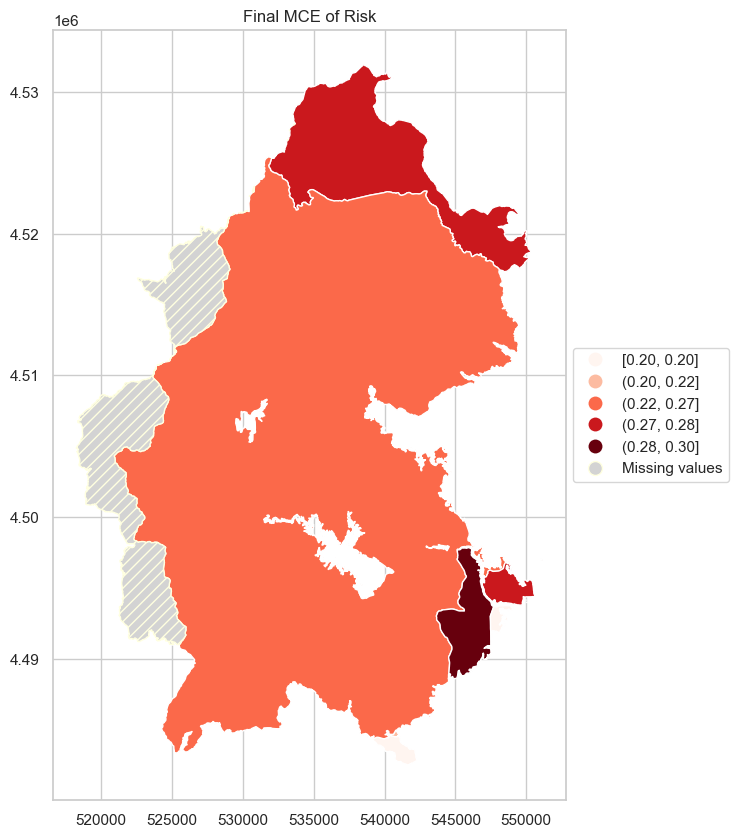

In [59]:
# Plot the final MCE
fig, ax = plt.subplots(figsize=(10, 10))   
ax.set_title('Final MCE of Risk')   
final_MCE_gdf.plot(ax=ax, column='MCE', scheme='NaturalBreaks', k=5,
             cmap='Reds', legend=True,
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),'interval': True},
             missing_kwds={"color": "lightgrey","edgecolor": "lightyellow","hatch": "///","label": "Missing values",})
